In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3

conn = sqlite3.connect('./database.sqlite')
c = conn.cursor()

In [15]:
c.execute("""SELECT m.id, c.name AS country_name, l.name AS league_name, season, stage, date,
             HT.team_long_name AS  home_team, AT.team_long_name AS away_team, home_team_goal, away_team_goal                                        
             FROM Match m
             JOIN Country c on c.id = m.country_id
             JOIN League l on l.id = m.league_id
             LEFT JOIN Team AS HT on HT.team_api_id = m.home_team_api_id
             LEFT JOIN Team AS AT on AT.team_api_id = m.away_team_api_id
             ORDER by date""")
df = pd.DataFrame(c.fetchall())
df.columns = [x[0] for x in c.description]
df.head(5)
#print(len(df))

,id,country_name,league_name,season,stage,date,home_team,away_team,home_team_goal,away_team_goal
0,24559,Switzerland,Switzerland Super League,2008/2009,1,2008-07-18 00:00:00,BSC Young Boys,FC Basel,1,2
1,24560,Switzerland,Switzerland Super League,2008/2009,1,2008-07-19 00:00:00,FC Aarau,FC Sion,3,1
2,24561,Switzerland,Switzerland Super League,2008/2009,1,2008-07-20 00:00:00,FC Luzern,FC Vaduz,1,2
3,24562,Switzerland,Switzerland Super League,2008/2009,1,2008-07-20 00:00:00,Neuchâtel Xamax,FC Zürich,1,2
4,24613,Switzerland,Switzerland Super League,2008/2009,2,2008-07-23 00:00:00,FC Basel,Grasshopper Club Zürich,1,0


In [16]:
df['date'] = pd.to_datetime(df.date)
df.loc[df["home_team_goal"] > df["away_team_goal"], "Home_Win"] = 1 
df.loc[df["away_team_goal"] > df["home_team_goal"], "Away_Win"] = 1 
df.loc[df["away_team_goal"] == df["home_team_goal"], "Draw"] = 1

In [17]:
df['Away_Win'] = df['Away_Win'].fillna(0)
df['Away_Win'] = df['Away_Win'].astype(int)
df['Home_Win'] = df['Home_Win'].fillna(0)
df['Home_Win'] = df['Home_Win'].astype(int)
df['Draw'] = df['Draw'].fillna(0)
df['Draw'] = df['Draw'].astype(int)

In [18]:
#Home_Record = df.groupby(['season', 'home_team'])['Home_Win', 'Away_Win', 'Draw'].sum()
Home_Record = df.groupby(['league_name', 'home_team'])['Home_Win', 'Away_Win', 'Draw'].sum()
Home_Record.rename(columns={'Away_Win': 'Home_Loss', 'Draw': 'Home_Draw'}, inplace=True)
Away_Record = df.groupby(['league_name','away_team'])['Home_Win', 'Away_Win', 'Draw'].sum()
Away_Record.rename(columns={'Home_Win': 'Away_Loss', 'Draw': 'Away_Draw'}, inplace=True)
Home_Record.index.names = ['league_name','team']
Away_Record.index.names = ['league_name','team']

In [19]:
Goals_Scored = (df.groupby(['league_name','home_team'])['home_team_goal'].sum()) + (df.groupby(['league_name','away_team'])['away_team_goal'].sum())
Goals_Allowed = (df.groupby(['league_name','home_team'])['away_team_goal'].sum()) + (df.groupby(['league_name','away_team'])['home_team_goal'].sum())
Goals_Allowed.index.names = ['league_name','team']
Goals_Scored.index.names = ['league_name','team']

In [20]:
df = pd.concat([Home_Record, Away_Record, Goals_Scored, Goals_Allowed], axis=1)
df.rename(columns={0: 'Goals_Scored', 1: 'Goals_Allowed' }, inplace=True)

In [21]:
df['Total_Wins'] = df['Home_Win'] + df['Away_Win']
df['Total_Losses'] = df['Home_Loss'] + df['Away_Loss']
df['Total_Draws'] = df['Home_Draw'] + df['Away_Draw']

In [22]:
df['Total_Matches'] = df['Total_Wins'] + df['Total_Losses'] + df['Total_Draws']

In [23]:
df['Win_%'] = ((df['Total_Wins']/df['Total_Matches'])*100).round(2)
df['Loss_%'] = ((df['Total_Losses']/df['Total_Matches'])*100).round(2)
df['Draw_%'] = ((df['Total_Draws']/df['Total_Matches'])*100).round(2)
df['Home_Win_%'] = ((df['Home_Win'])/(df['Home_Win'] + df['Home_Loss'] + df['Home_Draw'])*100).round(2)
df['Away_Win_%'] = ((df['Away_Win'])/(df['Away_Win'] + df['Away_Loss'] + df['Away_Draw'])*100).round(2)
df['Goals_per_Match'] = ((df['Goals_Scored']/df['Total_Matches'])*100).round(2)
df['Goals_Allowed_per_Match'] = ((df['Goals_Allowed']/df['Total_Matches'])*100).round(2)

In [24]:
pd.set_option('display.max_columns', 100)
df.head(5)

Home_Win  Home_Loss  Home_Draw  \
league_name            team                                             
Belgium Jupiler League Beerschot AC          30         21         25   
                       Club Brugge KV        75         13         18   
                       FCV Dender EH          5          8          4   
                       KAA Gent              63         27         19   
                       KAS Eupen              3          9          3   

                                       Away_Loss  Away_Win  Away_Draw  \
league_name            team                                             
Belgium Jupiler League Beerschot AC           49        10         17   
                       Club Brugge KV         36        48         22   
                       FCV Dender EH           9         4          4   
                       KAA Gent               27        46         36   
                       KAS Eupen               8         2          5   

                                       Goals_Scored  Goals_Allowed  \
league_name            team                                          
Belgium Jupiler League Beerschot AC             174            237   
                       Club Brugge KV           421            251   
                       FCV Dender EH             44             58   
                       KAA Gent                 390            253   
                       KAS Eupen                 28             50   

                                       Total_Wins  Total_Losses  Total_Draws  \
league_name            team                                                    
Belgium Jupiler League Beerschot AC            40            70           42   
                       Club Brugge KV         123            49           40   
                       FCV Dender EH            9            17            8   
                       KAA Gent               109            54           55   
                       KAS Eupen                5            17            8   

                                       Total_Matches  Win_%  Loss_%  Draw_%  \
league_name            team                                                   
Belgium Jupiler League Beerschot AC              152  26.32   46.05   27.63   
                       Club Brugge KV            212  58.02   23.11   18.87   
                       FCV Dender EH              34  26.47   50.00   23.53   
                       KAA Gent                  218  50.00   24.77   25.23   
                       KAS Eupen                  30  16.67   56.67   26.67   

                                       Home_Win_%  Away_Win_%  \
league_name            team                                     
Belgium Jupiler League Beerschot AC         39.47       13.16   
                       Club Brugge KV       70.75       45.28   
                       FCV Dender EH        29.41       23.53   
                       KAA Gent             57.80       42.20   
                       KAS Eupen            20.00       13.33   

                                       Goals_per_Match  \
league_name            team                              
Belgium Jupiler League Beerschot AC             114.47   
                       Club Brugge KV           198.58   
                       FCV Dender EH            129.41   
                       KAA Gent                 178.90   
                       KAS Eupen                 93.33   

                                       Goals_Allowed_per_Match  
league_name            team                                     
Belgium Jupiler League Beerschot AC                     155.92  
                       Club Brugge KV                   118.40  
                       FCV Dender EH                    170.59  
                       KAA Gent                         116.06  
                       KAS Eupen                        166.67

Comparing the Away Win Percentage amoung the 11 leagues in the dataset, I discover that the Away Win Percentage among the Scotland Premier League is unusually high.

league_name
Italy Serie A               22.414687
France Ligue 1              22.858571
Spain LIGA BBVA             23.568788
Netherlands Eredivisie      23.781600
Portugal Liga ZON Sagres    24.288276
Belgium Jupiler League      25.023750
England Premier League      25.063824
Poland Ekstraklasa          25.492273
Germany 1. Bundesliga       26.126333
Switzerland Super League    26.136667
Scotland Premier League     32.213529
Name: Away_Win_%, dtype: float64

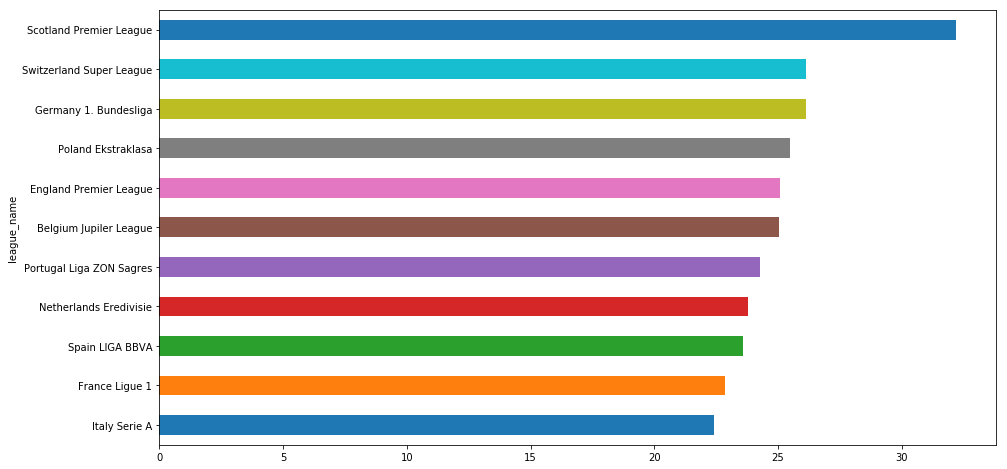

In [25]:
df.groupby(['league_name'])['Away_Win_%'].mean().sort_values().plot(kind='barh', figsize=(15,8))
df.groupby(['league_name'])['Away_Win_%'].mean().sort_values().head(14)

The above horizontal bar chart indicates that the away win percentage among teams in the Scotland Premier League is unusually high. I think that this value is statistically significant at the 0.05 p-value level.

In order to test this hypothesis, I need to find the mean and standard deviation for the away win percentage among all leagues in the dataset.

Just to be clear: the Null Hypothesis is that there is no difference between the away win % mean among teams in the Scotland Premier League and the away win percentage mean among teams across all leagues.

The Alternative Hypothesis that I am arguing for is that the high away win percentage of the Scotland Premier League is a noteworthy finding in the data that will be found statistically significant at the 0.05 level. Because I think the Scotland Premier League is greater (in a statistically significant way) than the population average, I will conduct a one-tail test.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11f31df28>]],
      dtype=object)

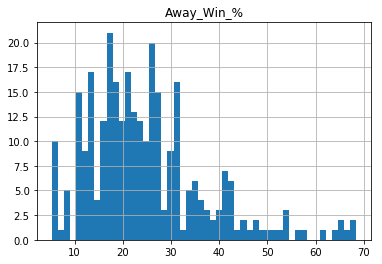

In [29]:
df.hist('Away_Win_%', bins=50)

In [26]:
df_mean = df['Away_Win_%'].mean()
df_std = df['Away_Win_%'].std()
print('df_mean is {} \df_std is {}'.format(df_mean,df_std))

df_mean is 24.766993243243245 \df_std is 12.422180493653412


Because the distribution of Away_Win_& is skewed to the right, I will create a sampling distribution from the data by drawing a high number of fairly large samples.

In [30]:
import numpy as np

def one_sample_mean(df):
    sample = np.random.choice(df,size=296,replace=True)
    return sample.mean()

one_sample_mean(df['Away_Win_%'])

24.938074324324326

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11f7b2160>]],
      dtype=object)

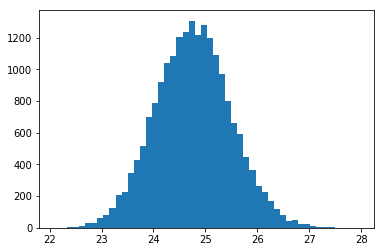

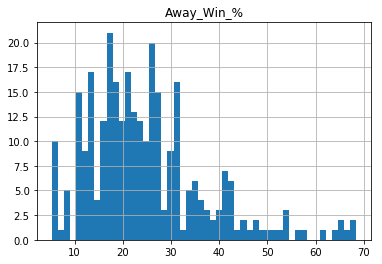

In [43]:
w = [one_sample_mean(df['Away_Win_%']) for i in range(20000)]
plt.hist(w,bins=50)
df.hist('Away_Win_%', bins=50)

The Scotland Premier League Away_Win_% is 32.213529. Just as a reminder, the general Away_Win_% is mean 24.76699 and the standard deviation is 12.42218.

In [71]:
import numpy as np
from scipy import stats
import itertools

Let's set a threshold value of $p = 0.05$ for rejecting the null hypothesis.

The standard error for our sample is: $\large\frac{\sigma}{\sqrt{n}} = \frac{12.422.18}{\sqrt{17}} = 3.01282$.

In [53]:
#standard error = standard deviation / sqrt of # of observations
se = 12.42218 / np.sqrt(17)
se

3.012821190613835

Even though our sample size is small (only 17 teams in the Scotland Premier League), the standard deviation of our population is known. Hence, the z-score is permissible.

The z-score will be: $\large\frac{\bar{x} - \mu}{se} = \frac{32.21353 - 24.76699}{3.01282} = \frac{7.44654}{3.01282} = 2.47$.

In [54]:
#t = (value you're interested in - mean)/ 
z = (32.21353 - 24.76699) / se
z

2.4716169758759676

In [58]:
p_value = scipy.stats.norm.sf(abs(z)) #one-sided
p_value

0.006725176967281055

In [72]:
1 - p_value

0.993274823032719

In [65]:
st.norm.cdf(2.4716) ## This is the "survival function": 1 - cdf(z)

0.9932745037152646

The "area of the tail" corresponding to this z-score is less than 1% (far less than 5%). Hence, we ought to reject the null hypothesis and conclude that the Away_Win_% in the Scotland Premier League is statistically significant!